In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
sp500 = pd.read_csv("data/sp500_companies.csv")
sp500_tickers = sp500['Symbol'].tolist()
df = yf.download(sp500_tickers, start="2021-01-01")['Close']

[*********************100%***********************]  502 of 502 completed


In [4]:
df.to_csv("data/sp500_prices.csv")

In [2]:
df = pd.read_csv('data/sp500_prices.csv', index_col=0)
returns = df.pct_change().dropna()
corr_returns = returns.corr()
cov_returns = returns.cov()

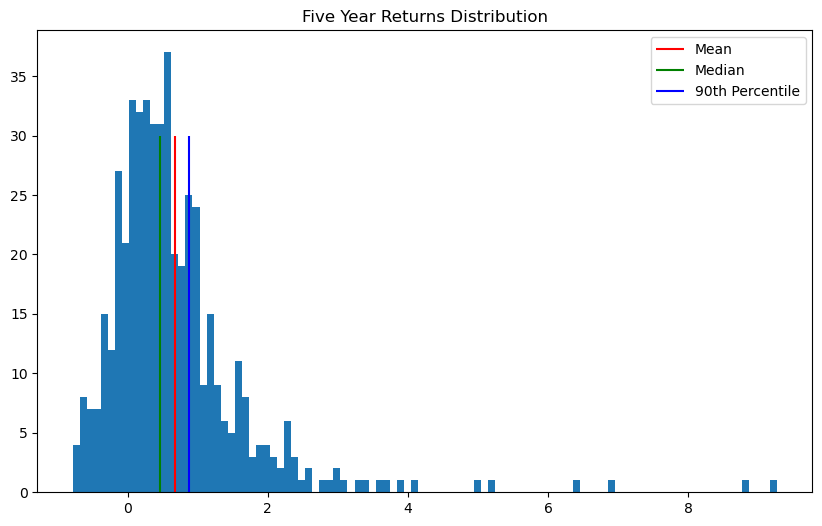

In [3]:
five_year_returns = df.iloc[-1] / df.iloc[0] - 1
plt.figure(figsize=(10, 6))
plt.hist(five_year_returns, bins=100)
plt.vlines(five_year_returns.mean(), ymin=0, ymax=30, color='r', label='Mean')
plt.vlines(five_year_returns.median(), ymin=0, ymax=30, color='g', label='Median')
# label 90th percentile|
plt.vlines(five_year_returns.quantile(0.7), ymin=0, ymax=30, color='b', label='90th Percentile')
plt.legend()
plt.title('Five Year Returns Distribution');

In [4]:
# only keep top 100
top_150 = five_year_returns.nlargest(150)
top_150_companies = top_150.index.tolist()
top_150_companies = df[top_150_companies]
top_150_companies_returns = top_150_companies.pct_change().dropna()
corr_top150 = top_150_companies_returns.corr()
cov_top150 = top_150_companies_returns.cov()

In [5]:
def select_low_corr_high_return(corr_mat, returns, k=20):
    mu = returns[corr_mat.columns]
    scores = mu.rank(pct=True) - corr_mat.abs().mean().rank(pct=True)
    return scores.nlargest(k).index.tolist()

In [6]:
selected_stocks = select_low_corr_high_return(corr_top150, five_year_returns, k=20)
selected_stocks = df[selected_stocks]
selected_stocks_returns = returns[selected_stocks.columns]
selected_stocks_returns = selected_stocks_returns.dropna()
selected_stocks_returns_corr = selected_stocks_returns.corr()

<Axes: >

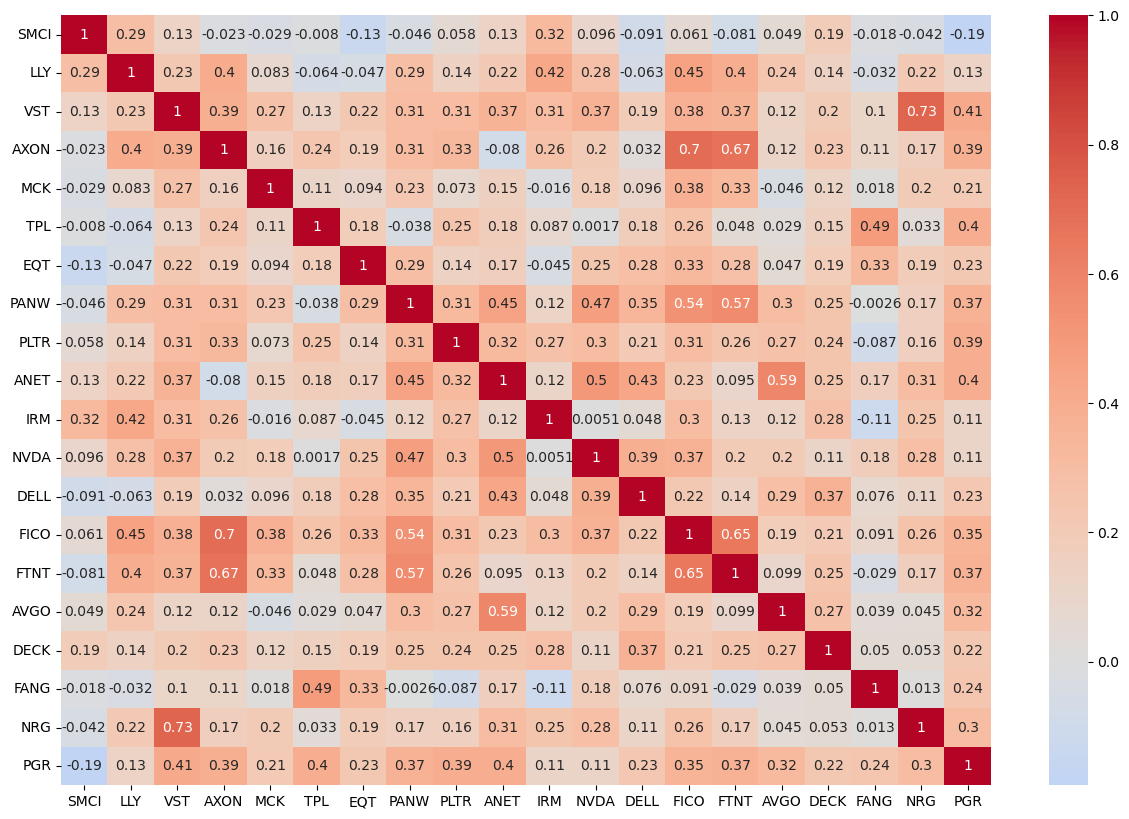

In [7]:
plt.figure(figsize=(15, 10))
sns.heatmap(selected_stocks_returns_corr, annot=True, cmap='coolwarm', center=0)

In [12]:
np.linalg.eigvals(selected_stocks_returns_corr.values)

array([5.3186259 , 2.05016528, 1.85852456, 1.5073    , 1.41606235,
       1.17426897, 1.0420623 , 0.9284439 , 0.82492114, 0.11174462,
       0.15178529, 0.18708061, 0.2208584 , 0.64089009, 0.2865467 ,
       0.3308376 , 0.38727395, 0.46830484, 0.50575092, 0.58855257])

In [8]:
top_150

NVDA    9.266582
SMCI    8.816425
VST     6.949503
TRGP    6.375015
ANET    5.245515
          ...   
PRU     0.877369
NI      0.876068
LEN     0.874083
WM      0.873297
JCI     0.865558
Length: 150, dtype: float64

In [15]:
scaler = StandardScaler()
sel = top_150.index.tolist()
mu = top_150.values
mu_scaled = scaler.fit_transform(mu.reshape(-1,1  )).flatten()
Sigma = cov_top150.values
C = corr_top150.abs().values
n = len(sel)

# Hyperparameters
alpha = 0.2    # reward for return
beta  = 0.8    # penalty for volatility
gamma = 5.0    # penalty for correlation
delta = 0.05   # penalty for L1 norm (sparsity)

# Define variable
w = cp.Variable(n)

# Objective
portfolio_return = mu_scaled @ w
portfolio_vol    = cp.quad_form(w, Sigma)
portfolio_corr   = cp.quad_form(w, C)
portfolio_l1     = cp.norm1(w)

objective = cp.Minimize(
    -alpha * portfolio_return +
     beta * portfolio_vol +
     gamma * portfolio_corr +
     delta * portfolio_l1
)

# Constraints
constraints = [
    cp.sum(w) == 1,
    w >= 0
]

# Solve
problem = cp.Problem(objective, constraints)
problem.solve()

# Results
opt_weights = pd.Series(w.value, index=sel)
opt_weights = opt_weights[opt_weights > 1e-4]

In [11]:
opt_weights

NVDA    0.132447
SMCI    0.189504
VST     0.120164
TRGP    0.037068
AXON    0.071890
LLY     0.053495
TPL     0.047387
EQT     0.014100
MCK     0.056652
PANW    0.003064
PGR     0.028977
CF      0.030649
CBOE    0.061703
KR      0.088764
ABBV    0.064186
dtype: float64

In [127]:
portfolio_returns = top_150_companies_returns[opt_weights.index]

# Compute daily portfolio return
daily_portfolio_return = portfolio_returns @ opt_weights

# Cumulative return
cumulative_return = (1 + daily_portfolio_return).cumprod()

# Metrics
annualized_return = daily_portfolio_return.mean() * 252
annualized_vol    = daily_portfolio_return.std() * np.sqrt(252)
sharpe_ratio      = annualized_return / annualized_vol

# Weighted correlation
weights = opt_weights.values
C_sub   = portfolio_returns.corr().abs().values
portfolio_correlation = weights @ C_sub @ weights

# Results
print(f"Annualized Return     : {annualized_return:.2%}")
print(f"Annualized Volatility : {annualized_vol:.2%}")
print(f"Sharpe Ratio          : {sharpe_ratio:.2f}")
print(f"Weighted Avg Corr     : {portfolio_correlation:.4f}")


Annualized Return     : 52.97%
Annualized Volatility : 25.03%
Sharpe Ratio          : 2.12
Weighted Avg Corr     : 0.2367


<Axes: xlabel='Ticker', ylabel='Ticker'>

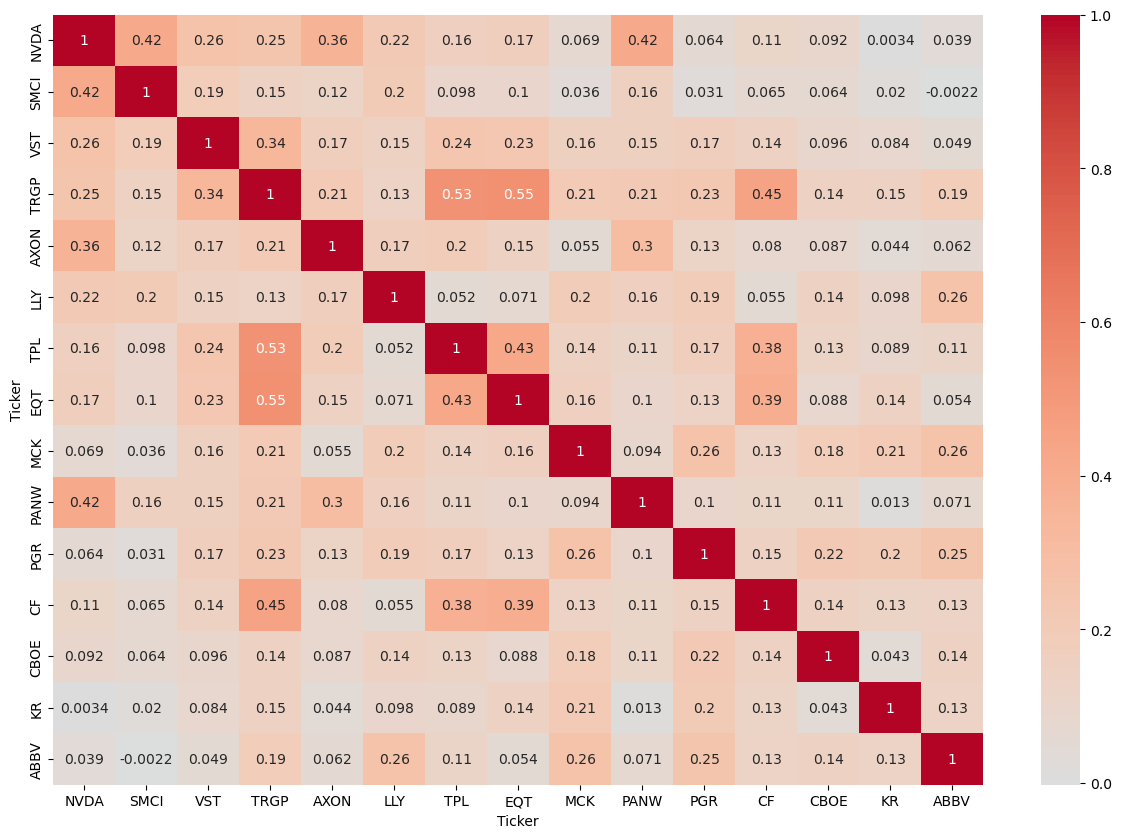

In [132]:
plt.figure(figsize=(15, 10))
sns.heatmap(portfolio_returns.corr(), annot=True, cmap='coolwarm', center=0)

In [109]:
yesterday = datetime.date.today() - datetime.timedelta(days=1)
test_data = yf.download(sp500_tickers, start="2025-01-01", end=yesterday.strftime("%Y-%m-%d"))['Close']


[*********************100%***********************]  502 of 502 completed


In [111]:
test_data.to_csv("data/sp500_test_prices.csv")

In [112]:
sp500_index = yf.download('^GSPC', start="2021-01-01", end=yesterday.strftime("%Y-%m-%d"))['Close']
sp500_index.to_csv("data/sp500_index_prices.csv")

[*********************100%***********************]  1 of 1 completed


In [123]:
sp500_index

Ticker,^GSPC
Date,
2021-01-04,3700.649902
2021-01-05,3726.860107
2021-01-06,3748.139893
2021-01-07,3803.790039
2021-01-08,3824.679932
...,...
2025-05-07,5631.279785
2025-05-08,5663.939941
2025-05-09,5659.910156


In [135]:
portfolio_cumulative_return

Date
2021-01-05    1.018133
2021-01-06    1.024405
2021-01-07    1.039504
2021-01-08    1.043541
2021-01-11    1.062969
                ...   
2024-12-24    7.600865
2024-12-26    7.579626
2024-12-27    7.421084
2024-12-30    7.326512
2024-12-31    7.275386
Length: 1004, dtype: float64

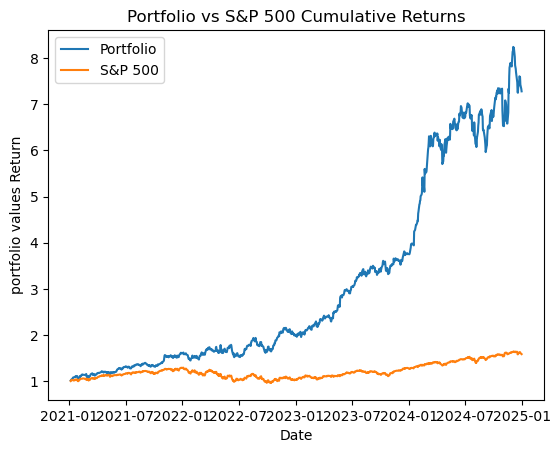

In [141]:
sp500_index_train = sp500_index[:'2025-01-01']
sp500_index_test = sp500_index['2025-01-01':]

daily_portfolio_return = portfolio_returns @ opt_weights
portfolio_cumulative_return = (1 + daily_portfolio_return).cumprod()

sp500_index_train_returns = sp500_index_train.pct_change().dropna()
sp500_index_cumulative_return_train = (1 + sp500_index_train_returns).cumprod()
dates = sp500_index_train.index[1:]
plt.figure()
plt.plot(dates, portfolio_cumulative_return, label='Portfolio')
plt.plot(dates, sp500_index_cumulative_return_train, label='S&P 500')
plt.title('Portfolio vs S&P 500 Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('portfolio values Return')
plt.legend()



In [142]:
portfolio_returns

Ticker,NVDA,SMCI,VST,TRGP,AXON,LLY,TPL,EQT,MCK,PANW,PGR,CF,CBOE,KR,ABBV
Date,,,,,,,,,,,,,,,
2021-01-05,0.022210,0.003543,0.033368,0.061927,0.046641,0.004955,0.050809,0.046980,0.006708,-0.004294,-0.001853,0.039969,-0.000648,-0.007158,0.010340
2021-01-06,-0.058953,0.023427,0.023714,0.027718,-0.004988,-0.012025,-0.002491,0.065527,0.018964,-0.013908,0.018979,0.065635,0.031550,0.009718,-0.008638
2021-01-07,0.057830,0.009407,-0.005422,0.067250,0.023667,0.009189,-0.018082,-0.001337,0.022858,0.051639,0.005839,0.001639,0.013826,-0.012108,0.010703
2021-01-08,-0.005040,-0.009630,0.040139,-0.041680,0.006342,0.003497,0.028664,-0.028113,0.002896,0.009474,-0.002533,0.009119,0.020870,-0.005971,0.005248
2021-01-11,0.025967,0.006901,0.008576,0.000342,-0.004148,0.117361,0.085518,0.048210,-0.000817,-0.004774,0.006243,-0.001159,0.010019,0.004110,0.016314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.003938,0.059568,0.018254,0.013175,0.011392,-0.000766,0.019088,0.016416,0.004109,0.006854,0.009253,0.006482,0.006784,0.014272,0.009025
2024-12-26,-0.002068,-0.017186,0.005232,-0.015604,-0.011802,-0.001923,0.005004,-0.008973,-0.001209,-0.005330,-0.000206,-0.003630,0.011008,0.015041,-0.004444
2024-12-27,-0.020868,-0.052164,-0.030740,-0.003035,-0.020551,-0.013814,-0.018757,0.003169,-0.003095,-0.012308,-0.008923,-0.003996,0.003460,-0.006692,-0.006641


In [146]:
five_year_returns[portfolio_returns.columns]

Ticker
NVDA    9.266582
SMCI    8.816425
VST     6.949503
TRGP    6.375015
AXON    4.086179
LLY     3.879052
TPL     3.635487
EQT     2.617097
MCK     2.351798
PANW    2.104590
PGR     1.667834
CF      1.411337
CBOE    1.210504
KR      1.075086
ABBV    0.979445
dtype: float64

In [147]:
# calculate sharpe ratio of sp500 index
sp500_index_returns = sp500_index.pct_change().dropna()
sp500_index_annualized_return = sp500_index_returns.mean() * 252
sp500_index_annualized_vol = sp500_index_returns.std() * np.sqrt(252)
sp500_index_sharpe_ratio = sp500_index_annualized_return / sp500_index_annualized_vol
sp500_index_sharpe_ratio

Ticker
^GSPC    0.693394
dtype: float64